In [36]:
import torch
import pandas as pd
import os
main_dir = '../wind-profiles'
#directories = ['CR1992', 'CR2056', 'CR2071', 'CR2125', 'CR2210']
directories = []
total_size = 640
segment_to_skip = 100

# three dimensional tensors, with shape (len(dir), 640, 9) and (len(dir), 640, 3)
X_data = torch.empty(0, total_size - segment_to_skip, 5)
y_data = torch.empty(0, total_size - segment_to_skip, 3)

for directory in directories:
    for file_ in os.listdir(f'{main_dir}/{directory}'):
        data = pd.read_csv(f'{main_dir}/{directory}/{file_}', delimiter=',', 
                        header=0, names=['R', 'L', 'Lon', 'Lat', 'n', 'v', 'T', 'B', 'A/A0', 'alpha', 'V/Cs', 'propag_dt'], 
                        skiprows=2, dtype=float, na_values=['                      NaN', '                     -NaN'])
        
        # if data has NaN values in R column, continue to next file
        if data[['R', 'B', 'alpha', 'A/A0', 'n', 'v', 'T']].isnull().values.any():
            continue
        
        # convert to tensor, with shape (len(data), 3), where the three channels are R, B, alpha
        X_sample = torch.tensor(data[['R', 'L', 'B', 'A/A0', 'alpha']].values, dtype=torch.float32)
        y_sample = torch.tensor(data[['n', 'v', 'T']].values, dtype=torch.float32)
        
        X_data = torch.cat((X_data, X_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)
        y_data = torch.cat((y_data, y_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)

In [37]:
# load tensors from file
X_data = torch.load('X_data_train.pt')
y_data = torch.load('y_data_train.pt')

In [38]:
y_data[:, 0, :] = torch.abs(y_data[:, 0, :])

In [ ]:
torch.save(y_data, 'y_data_train.pt')

In [3]:
# get indices of samples where A/A0 is smaller than 0
indices = (X_data[:, 3, :] < 0).sum(dim=1)

non_zero_indices = indices.nonzero().squeeze()
non_zero_indices

tensor([ 280,  491,  840,  906, 1057, 1368, 1456, 1475, 1608, 1773, 3246, 3331,
        3335, 3458, 3459, 3489, 3581, 3604, 3623, 3630, 3654, 4857, 5017, 5066,
        5071, 5351, 5352, 5354, 5357, 5364, 5366, 5368, 5661, 6821, 6972, 7482,
        8112])

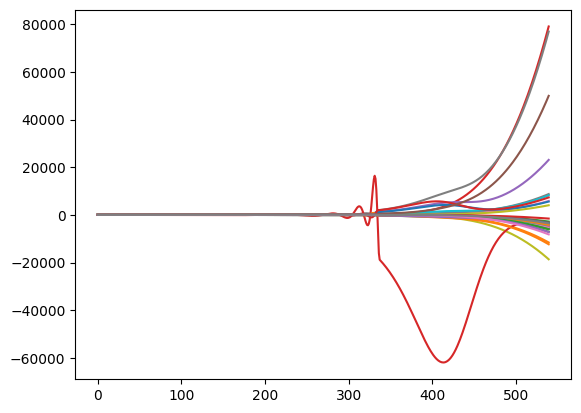

In [52]:
import matplotlib.pyplot as plt

plt.plot(X_data[non_zero_indices, 3, :].T)
plt.show()

In [53]:
# outlier 
# get indices of samples where A/A0 is smaller than 0
outlier = (X_data[:, 3, :] < - 40000).sum(dim=1)

outlier = outlier.nonzero().squeeze()
outlier

tensor(3438)

In [54]:
# remove outlier
X_data = torch.cat((X_data[:outlier], X_data[outlier+1:]), dim=0)
y_data = torch.cat((y_data[:outlier], y_data[outlier+1:]), dim=0)

In [55]:
# get indices of samples where A/A0 is smaller than 0
indices = (X_data[:, 3, :] < 0).sum(dim=1)

non_zero_indices = indices.nonzero().squeeze()
non_zero_indices

tensor([ 280,  491,  840,  906, 1057, 1368, 1456, 1475, 1608, 1773, 3246, 3331,
        3335, 3458, 3459, 3489, 3581, 3604, 3623, 3630, 3654, 4857, 5017, 5066,
        5071, 5351, 5352, 5354, 5357, 5364, 5366, 5368, 5661, 6821, 6972, 7482,
        8112])

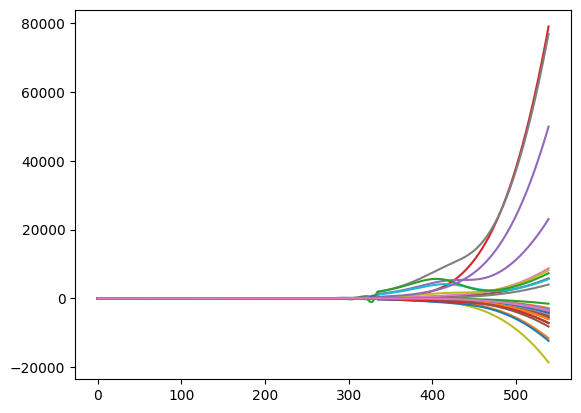

In [56]:
import matplotlib.pyplot as plt

plt.plot(X_data[non_zero_indices, 3, :].T)
plt.show()

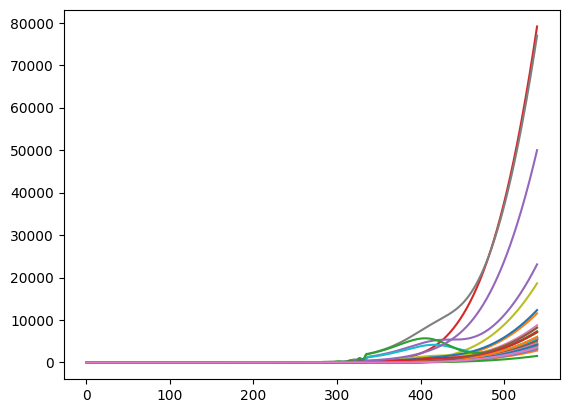

In [57]:
import matplotlib.pyplot as plt

plt.plot(torch.abs(X_data[non_zero_indices, 3, :]).T)
plt.show()

In [58]:
# save tensors to file
torch.save(X_data, 'X_data_train.pt')
torch.save(y_data, 'y_data_train.pt')

In [3]:
X_data[:, 2, :] = torch.abs(X_data[:, 2, :])
X_data[:, 3, :] = torch.abs(X_data[:, 3, :])

# Analysis for Inputs

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Initialize a dictionary to hold the statistical measures for each variable
stats = {
    'Variable': [],
    'Mean': [],
    'Median': [],
    'Std': [],
    'Skewness': [],
    'Kurtosis': []
}

# Calculate statistics for each variable
for i in range(5):
    variable_data = X_data[:, i, :].numpy().flatten()  # Flatten to treat all points equally
    stats['Variable'].append(f'Variable {i+1}')
    stats['Mean'].append(np.mean(variable_data))
    stats['Median'].append(np.median(variable_data))
    stats['Std'].append(np.std(variable_data))
    stats['Skewness'].append(skew(variable_data))
    stats['Kurtosis'].append(kurtosis(variable_data))

# Convert stats dictionary to a DataFrame for easier viewing
stats_df = pd.DataFrame(stats)

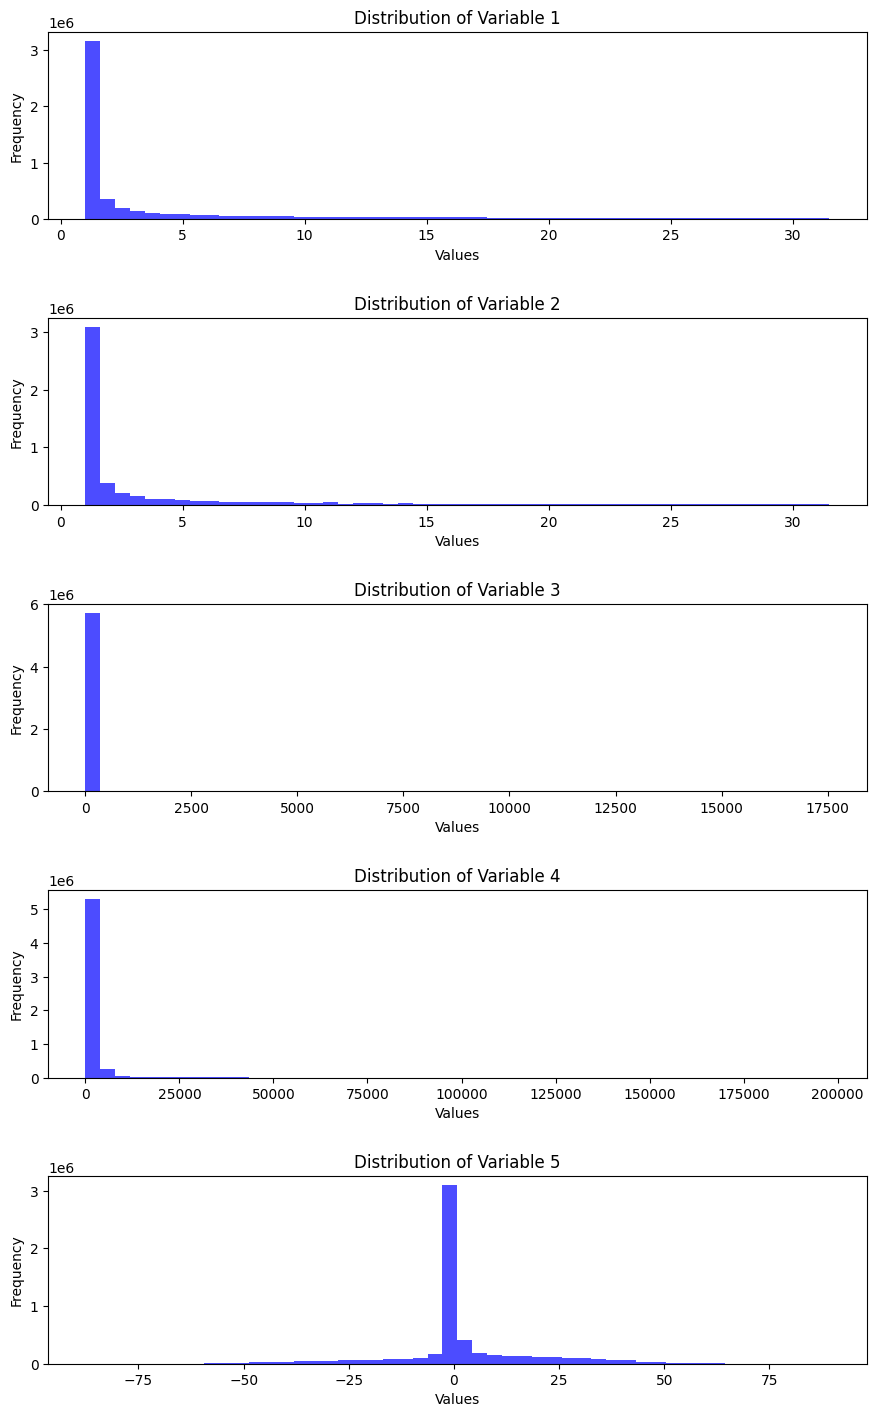

(     Variable         Mean    Median          Std    Skewness       Kurtosis
 0  Variable 1     5.450089  1.363965     7.599890    1.872413       2.404290
 1  Variable 2     5.518898  1.411528     7.642969    1.860661       2.363347
 2  Variable 3     4.173382  1.003374    12.962860  447.305148  589347.445784
 3  Variable 4  1256.963996  6.015182  5897.568887   11.954025     191.198876
 4  Variable 5     2.266041  0.000000    15.987142    0.139726       2.993707,
 None)

In [6]:
# Plotting
fig, axs = plt.subplots(5, 1, figsize=(10, 15))
fig.tight_layout(pad=5.0)
for i in range(5):
    axs[i].hist(X_data[:, i, :].numpy().flatten(), bins=50, color='blue', alpha=0.7)
    axs[i].set_title(f'Distribution of Variable {i+1}')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlabel('Values')

stats_df, plt.show()  # Display statistics and plots

In [ ]:
# qq plots
import scipy.stats as stats
import numpy as np

fig, axs = plt.subplots(5, 1, figsize=(10, 15))
fig.tight_layout(pad=5.0)
for i in range(5):
    stats.probplot(X_data[:, i, :].numpy().flatten(), dist="norm", plot=axs[i])
    axs[i].set_title(f'Q-Q plot of Variable {i+1}')
    axs[i].set_xlabel('Theoretical quantiles')
    axs[i].set_ylabel('Observed quantiles')

In [12]:
import torch
from sklearn.preprocessing import RobustScaler
import numpy as np

class TensorRobustScaler:
    def __init__(self):
        self.median = None
        self.iqr = None
        
    def fit(self, X):
        self.median = torch.quantile(X, 0.5, dim=-1, keepdim=True)
        q1 = torch.quantile(X, 0.25, dim=-1, keepdim=True)
        q3 = torch.quantile(X, 0.75, dim=-1, keepdim=True)
        self.iqr = q3 - q1
        
    def transform(self, X):
        return (X - self.median) / self.iqr
    
    def inverse_transform(self, X):
        return (X * self.iqr) + self.median

def get_normalization_info_inputs(X):
    X_normalized = X.clone()
    normalization_info = {}
    
    for var in [0, 1]:
        X_var = X_normalized[:, var, :]
        X_var_transformed = torch.log1p(X_var)
        mean = X_var_transformed.mean()
        std = X_var_transformed.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "log_standardization"}
    
    for var in [2, 3]:
        tensor_robust_scaler = TensorRobustScaler()
        X_var = X_normalized[:, var, :]
        X_var_transformed = torch.log1p(X_var)
        tensor_robust_scaler.fit(X_var_transformed)
        normalization_info[var] = {"scaler": tensor_robust_scaler, "method": "log_robust_scaling"}
        
    for var in [4]:
        X_var = X_normalized[:, var, :]
        mean = X_var.mean()
        std = X_var.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "standardization"}
        
    return normalization_info

def normalize(X, normalization_info):
    X_normalized = X.clone()
    
    for var, info in normalization_info.items():
        if info["method"] == "standardization":
            mean = info["mean"]
            std = info["std"]
            X_normalized[:, var, :] = (X_normalized[:, var, :] - mean) / std
        if info["method"] == "log_standardization":
            mean = info["mean"]
            std = info["std"]
            X_normalized[:, var, :] = (torch.log1p(X_normalized[:, var, :]) - mean) / std
        elif info["method"] == "log_robust_scaling":
            scaler = info["scaler"]
            X_normalized[:, var, :] = scaler.transform(torch.log1p(X_normalized[:, var, :]))
    
    return X_normalized

def denormalize(X_normalized, normalization_info):
    X_denormalized = X_normalized.clone()
    
    for var, info in normalization_info.items():
        if info["method"] == "standardization":
            mean = info["mean"]
            std = info["std"]
            X_denormalized[:, var, :] = (X_denormalized[:, var, :] * std) + mean
        if info["method"] == "log_standardization":
            mean = info["mean"]
            std = info["std"]
            X_denormalized[:, var, :] = torch.expm1((X_denormalized[:, var, :] * std) + mean)
        elif info["method"] == "log_robust_scaling":
            scaler = info["scaler"]
            X_denormalized[:, var, :] = torch.expm1(scaler.inverse_transform(X_denormalized[:, var, :]))
    
    return X_denormalized

In [13]:
normalization_info_inputs = get_normalization_info_inputs(X_data)
X_data_normalized = normalize(X_data, normalization_info_inputs)

In [14]:
X_data_normalized[0, :, :]

tensor([[-0.7762, -0.7761, -0.7761,  ...,  2.3497,  2.3590,  2.3683],
        [-0.7882, -0.7881, -0.7880,  ...,  2.3356,  2.3448,  2.3540],
        [ 0.7659,  0.7657,  0.7656,  ..., -0.3202, -0.3202, -0.3202],
        [-0.3447, -0.3446, -0.3446,  ...,  1.2117,  1.2141,  1.2162],
        [-0.1483, -0.1481, -0.1479,  ..., -0.1420, -0.1420, -0.1420]],
       dtype=torch.float64)

In [15]:
X_data_denormalized = denormalize(X_data_normalized, normalization_info_inputs)

In [16]:
(X_data[0, :, :] - X_data_denormalized[0, :, :]).abs().sum()

tensor(5.5134e-10, dtype=torch.float64)

# Analysis for Outputs

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# Initialize a dictionary to hold the statistical measures for each variable
stats = {
    'Variable': [],
    'Mean': [],
    'Median': [],
    'Std': [],
    'Skewness': [],
    'Kurtosis': []
}

# Calculate statistics for each variable
for i in range(3):
    variable_data = y_data[:, i, :].numpy().flatten()  # Flatten to treat all points equally
    stats['Variable'].append(f'Variable {i+1}')
    stats['Mean'].append(np.mean(variable_data))
    stats['Median'].append(np.median(variable_data))
    stats['Std'].append(np.std(variable_data))
    stats['Skewness'].append(skew(variable_data))
    stats['Kurtosis'].append(kurtosis(variable_data))

# Convert stats dictionary to a DataFrame for easier viewing
stats_df = pd.DataFrame(stats)

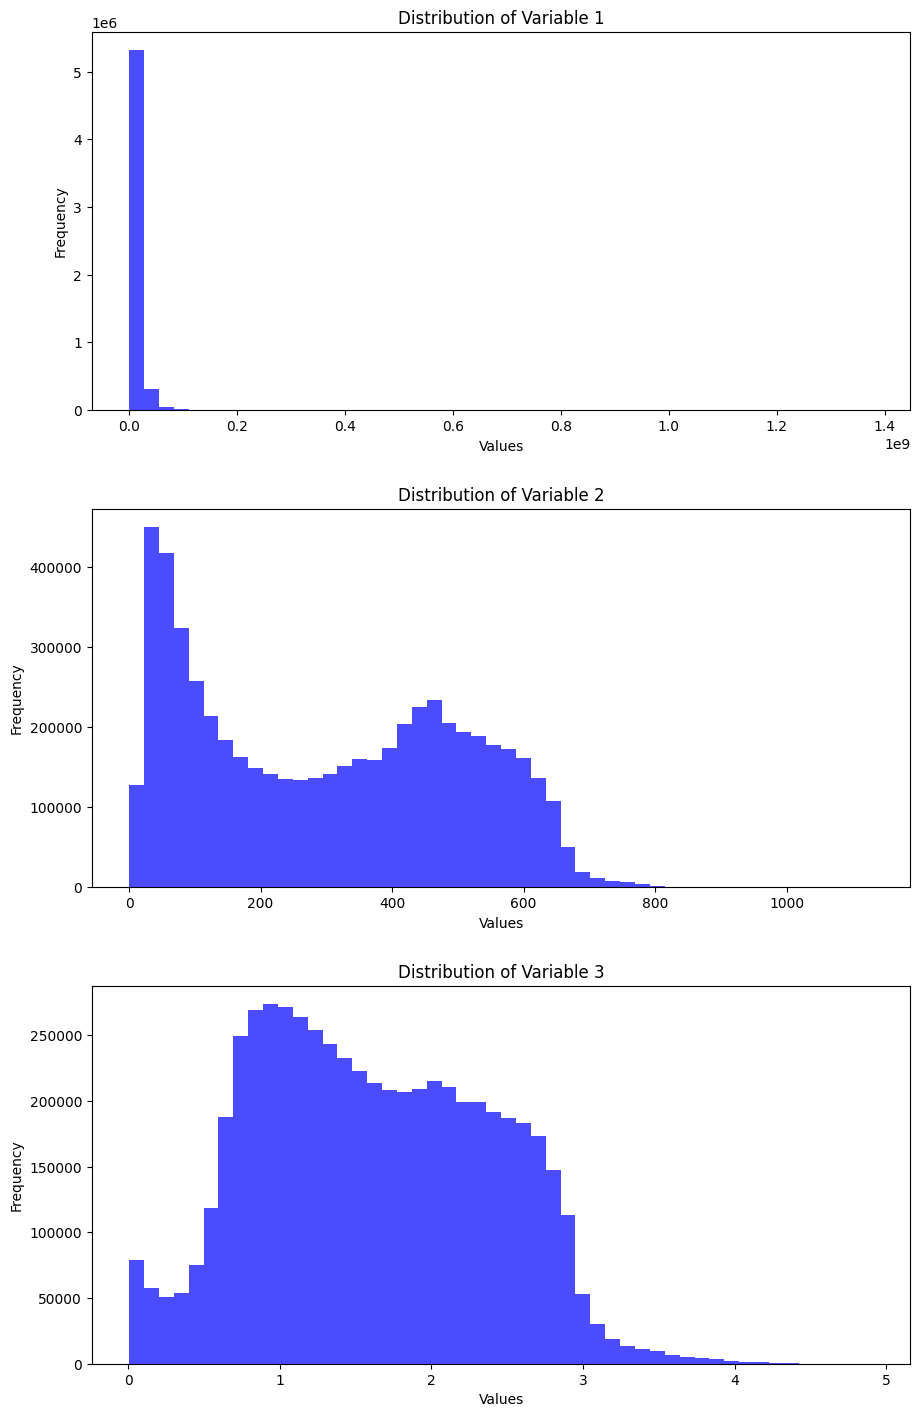

(     Variable          Mean         Median           Std  Skewness    Kurtosis
 0  Variable 1  7.539610e+06  647343.125000  1.726924e+07  9.664854  235.077235
 1  Variable 2  3.013274e+02     298.810333  2.024155e+02  0.155911   -1.313253
 2  Variable 3  1.613033e+00       1.557080  7.694372e-01  0.171579   -0.703927,
 None)

In [13]:
# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
fig.tight_layout(pad=5.0)
for i in range(3):
    axs[i].hist(y_data[:, i, :].numpy().flatten(), bins=50, color='blue', alpha=0.7)
    axs[i].set_title(f'Distribution of Variable {i+1}')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlabel('Values')

stats_df, plt.show()  # Display statistics and plots

In [ ]:
# qq plots
import scipy.stats as stats
import numpy as np

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
fig.tight_layout(pad=5.0)
for i in range(3):
    stats.probplot(y_data[:, i, :].numpy().flatten(), dist="norm", plot=axs[i])
    axs[i].set_title(f'Q-Q plot of Variable {i+1}')
    axs[i].set_xlabel('Theoretical quantiles')
    axs[i].set_ylabel('Observed quantiles')

In [18]:
def get_normalization_info_outputs(y):
    y_normalized = y.clone()
    normalization_info = {}
    
    for var in [0]:
        y_var = y_normalized[:, var, :]
        y_var_transformed = torch.log1p(y_var)
        mean = y_var_transformed.mean()
        std = y_var_transformed.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "log_standardization"}
        
    for var in [1, 2]:
        y_var = y_normalized[:, var, :]
        mean = y_var.mean()
        std = y_var.std()
        normalization_info[var] = {"mean": mean, "std": std, "method": "standardization"}
    
    return normalization_info

In [19]:
normalization_info_outputs = get_normalization_info_outputs(y_data)
y_data_normalized = normalize(y_data, normalization_info_outputs)

In [34]:
# get indices of y_data where n is negative
indices = (y_data[:, 0, :] < 0).sum(dim=1).nonzero().squeeze()

indices

tensor([3047, 5284, 6787, 6853, 6916, 6993, 9173, 9225, 9612, 9681])

In [17]:
y_denormalized = denormalize(y_data_normalized, normalization_info_outputs)

In [18]:
y_denormalized[0, :, :] == y_data[0, :, :]

tensor([[False,  True, False,  ...,  True, False,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]])

In [19]:
(y_denormalized[0, :, :] - y_data[0, :, :]).abs().sum()

tensor(4.2987e-06, dtype=torch.float64)

# Smoothing

In [74]:
# apply fft to the data
import torch.fft

X_b = torch.fft.fft(X_data[:, 2, :], dim=-1)
X_a_a0 = torch.fft.fft(X_data[:, 3, :], dim=-1)

In [76]:
X_b[0].shape, X_a_a0[0].shape

(torch.Size([540]), torch.Size([540]))

In [77]:
import numpy as np

magnitude = np.sqrt(X_b.real**2 + X_b.imag**2)

avg_magnitude = np.mean(magnitude.numpy(), axis=1)

threshold = np.percentile(avg_magnitude, 99.9)

filtered_indices_b = np.where(avg_magnitude > threshold)[0]
non_filtered_indices_b = np.where(avg_magnitude <= threshold)[0]
len(filtered_indices_b)

11

In [78]:
magnitude = np.sqrt(X_a_a0.real**2 + X_a_a0.imag**2)

avg_magnitude = np.mean(magnitude.numpy(), axis=1)

threshold = np.percentile(avg_magnitude, 99.9)

filtered_indices_a_a0 = np.where(avg_magnitude > threshold)[0]
non_filtered_indices_a_a0 = np.where(avg_magnitude <= threshold)[0]
len(filtered_indices_a_a0)

11

In [79]:
# merge the two lists and remove duplicates
filtered_indices = np.unique(np.concatenate((filtered_indices_b, filtered_indices_a_a0)))

filtered_indices

array([ 491,  906, 1368, 1475, 3246, 3459, 3489, 3581, 3630, 3654, 6966,
       6972, 6998, 6999, 7000, 7003, 7062, 7063, 7064, 7065, 7128, 7129],
      dtype=int64)

Text(0, 0.5, 'Amplitude')

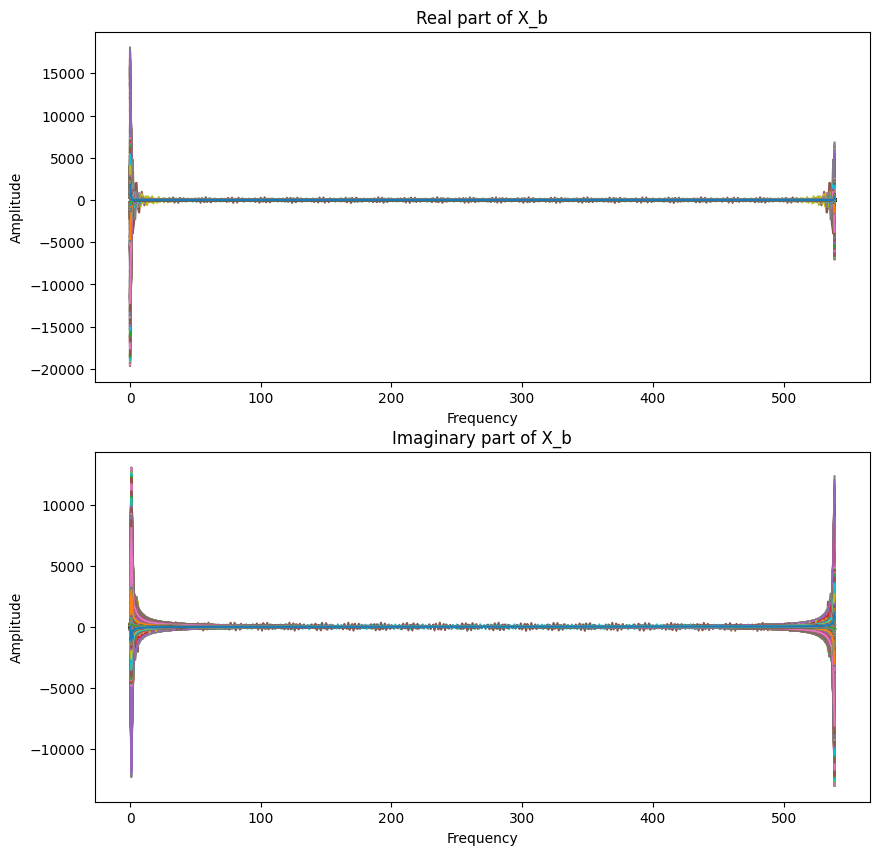

In [49]:
import matplotlib.pyplot as plt

# show X_b and its absolute values
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(X_b[non_filtered_indices_b, :].real.T.numpy())
axs[0].set_title('Real part of X_b')
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Amplitude')

axs[1].plot(X_b[non_filtered_indices_b, :].imag.T.numpy())
axs[1].set_title('Imaginary part of X_b')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Amplitude')

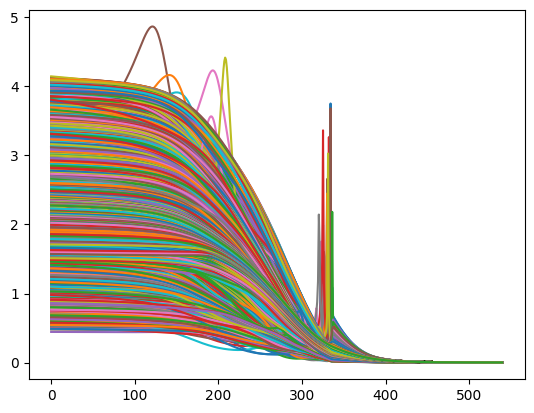

In [24]:
# plot filtered indices
plt.plot(torch.log1p(abs(X_data[non_filtered_indices_b, 2, :])).T)
plt.show()

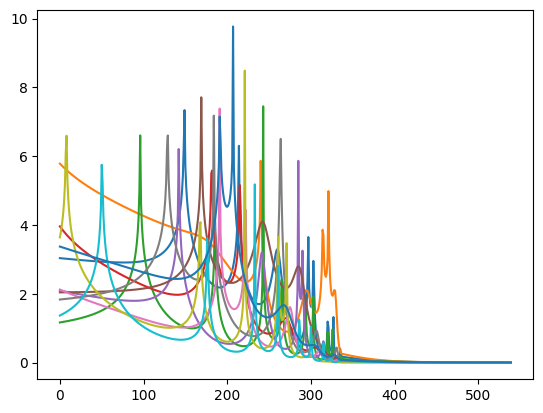

In [80]:
# plot filtered indices
plt.plot(torch.log1p(abs(X_data[filtered_indices_b, 2, :])).T)
plt.show()

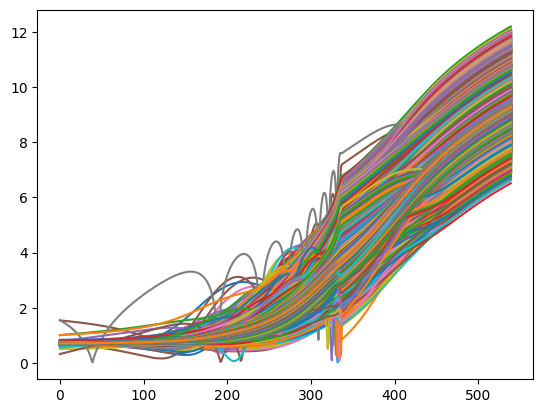

In [84]:
# plot filtered indices
plt.plot(torch.log1p(abs(X_data[non_filtered_indices_b, 3, :])).T)
plt.show()

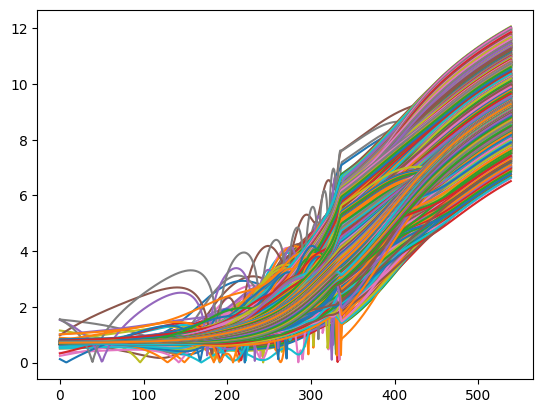

In [82]:
# plot filtered indices
plt.plot(torch.log1p(abs(X_data[non_filtered_indices_a_a0, 3, :])).T)
plt.show()

Text(0, 0.5, 'Amplitude')

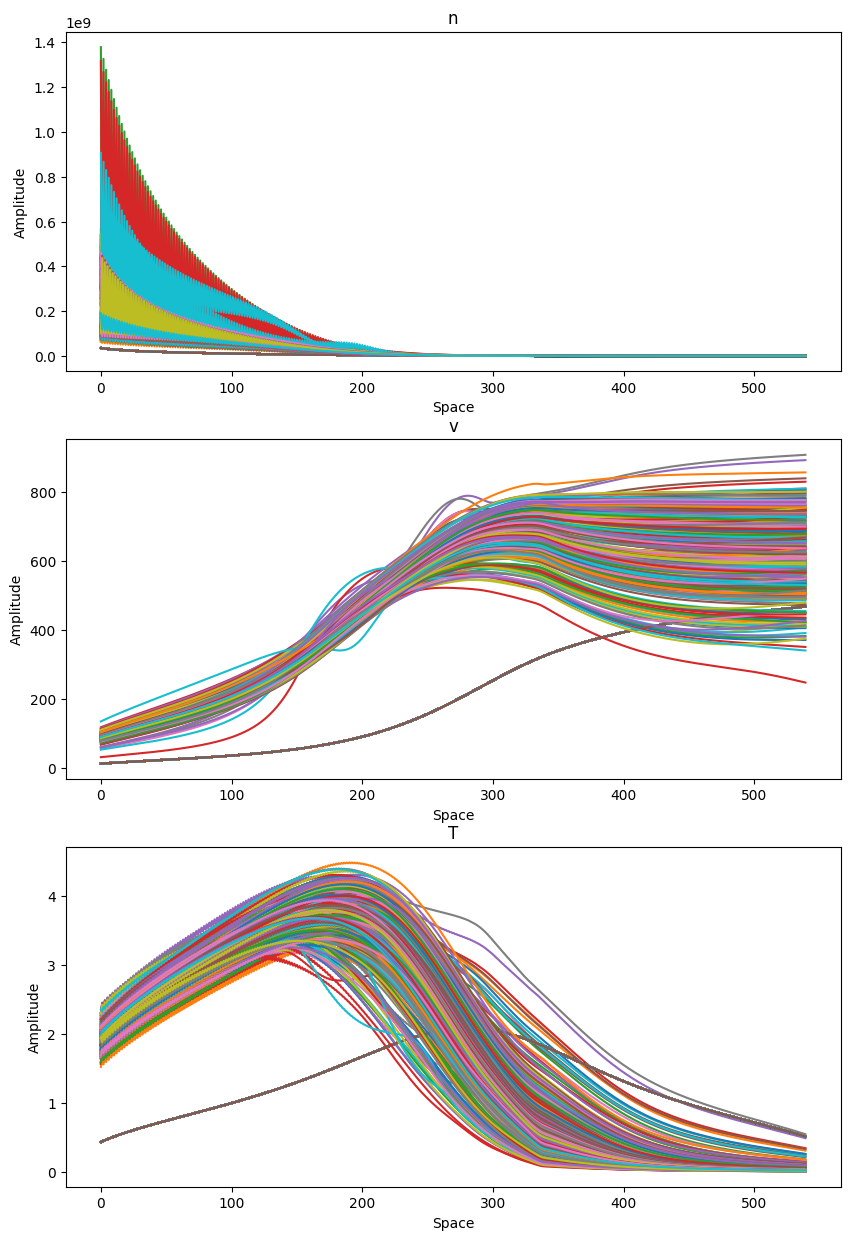

In [75]:
# show outputs
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

axs[0].plot(y_data[filtered_indices, 0, :].T.numpy())
axs[0].set_title('n')
axs[0].set_xlabel('Space')
axs[0].set_ylabel('Amplitude')

axs[1].plot(y_data[filtered_indices, 1, :].T.numpy())
axs[1].set_title('v')
axs[1].set_xlabel('Space')
axs[1].set_ylabel('Amplitude')

axs[2].plot(y_data[filtered_indices, 2, :].T.numpy())
axs[2].set_title('T')
axs[2].set_xlabel('Space')
axs[2].set_ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

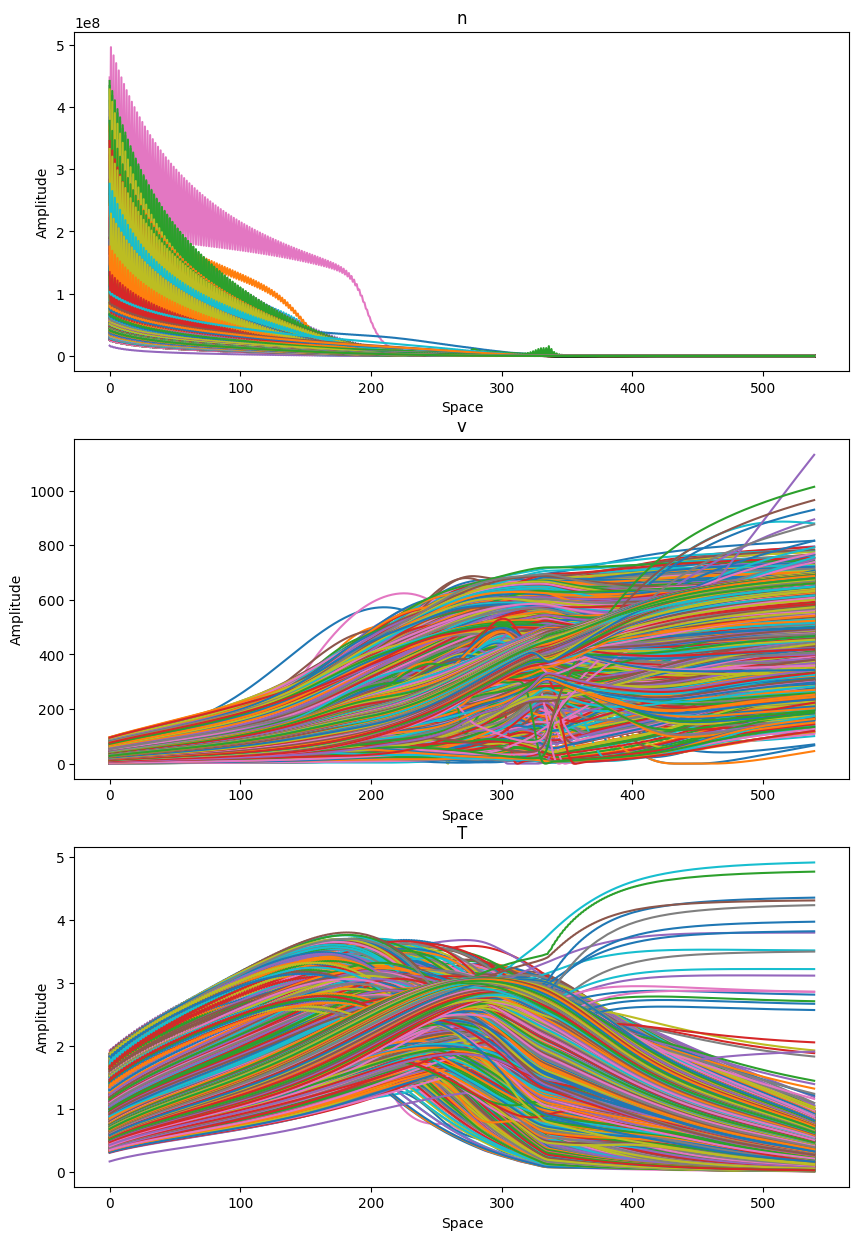

In [72]:
# show outputs
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

axs[0].plot(y_data[non_filtered_indices, 0, :].T.numpy())
axs[0].set_title('n')
axs[0].set_xlabel('Space')
axs[0].set_ylabel('Amplitude')

axs[1].plot(y_data[non_filtered_indices, 1, :].T.numpy())
axs[1].set_title('v')
axs[1].set_xlabel('Space')
axs[1].set_ylabel('Amplitude')

axs[2].plot(y_data[non_filtered_indices, 2, :].T.numpy())
axs[2].set_title('T')
axs[2].set_xlabel('Space')
axs[2].set_ylabel('Amplitude')

In [87]:
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np

# Butterworth Low-pass Filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    data_ = data.clone()
    
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data_)
    return y

# Apply the filter
filtered_x = X_data.clone()
#filtered_y = y_data.clone()


filtered_x[:, 2, :] = torch.Tensor(butter_lowpass_filter(X_data[:, 2, :], 3.667, 100, 6).copy())
filtered_x[:, 3, :] = torch.Tensor(butter_lowpass_filter(X_data[:, 3, :], 3.667, 100, 6).copy())
filtered_y = butter_lowpass_filter(y_data, 3.667, 100, 6)

In [88]:
# remove filtered indices
filtered_x = filtered_x[non_filtered_indices_b, :, :]
filtered_y = filtered_y[non_filtered_indices_b, :, :]

Text(0, 0.5, 'Amplitude')

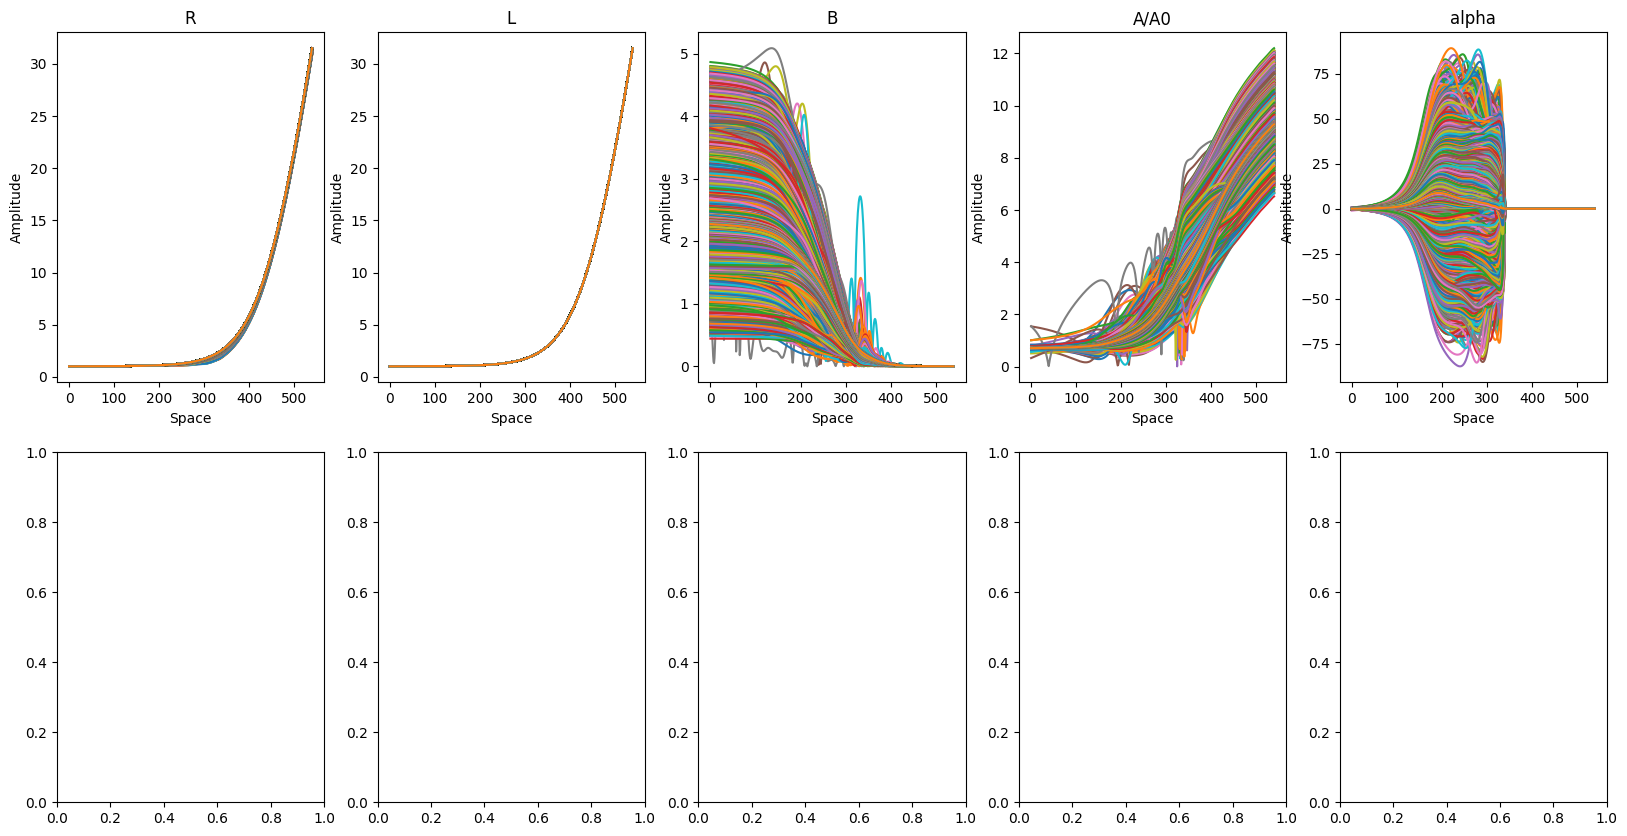

In [89]:
# show inputs

fig, axs = plt.subplots(2, 5, figsize=(20, 10))

axs[0, 0].plot(filtered_x[:, 0, :].T)
axs[0, 0].set_title('R')
axs[0, 0].set_xlabel('Space')
axs[0, 0].set_ylabel('Amplitude')

axs[0, 1].plot(filtered_x[:, 1, :].T)
axs[0, 1].set_title('L')
axs[0, 1].set_xlabel('Space')
axs[0, 1].set_ylabel('Amplitude')

axs[0, 2].plot(np.log1p(abs(filtered_x[:, 2, :])).T)
axs[0, 2].set_title('B')
axs[0, 2].set_xlabel('Space')
axs[0, 2].set_ylabel('Amplitude')

axs[0, 3].plot(np.log1p(abs(filtered_x[:, 3, :])).T)
axs[0, 3].set_title('A/A0')
axs[0, 3].set_xlabel('Space')
axs[0, 3].set_ylabel('Amplitude')

axs[0, 4].plot(filtered_x[:, 4, :].T)
axs[0, 4].set_title('alpha')
axs[0, 4].set_xlabel('Space')
axs[0, 4].set_ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

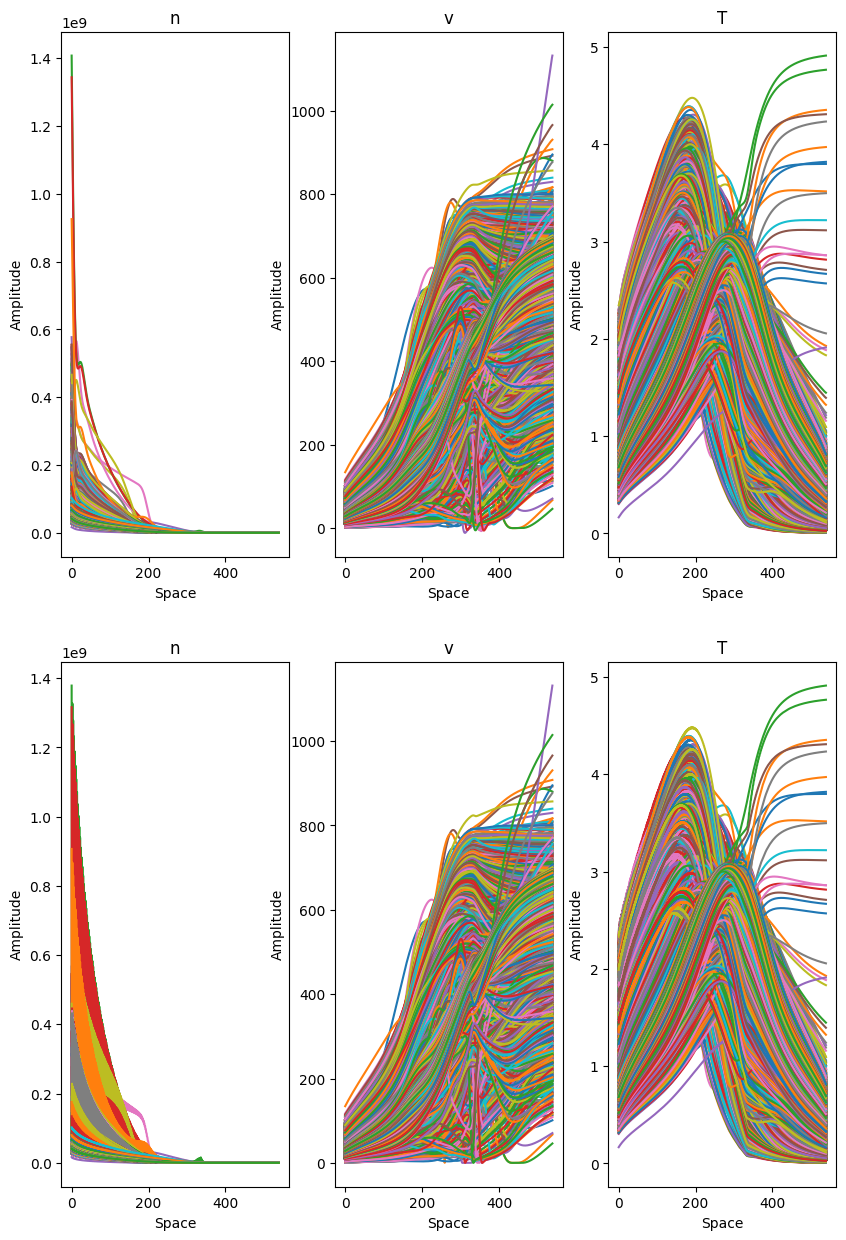

In [27]:
# show outputs
fig, axs = plt.subplots(2, 3, figsize=(10, 15))

axs[0, 0].plot(filtered_y[:, 0, :].T)
axs[0, 0].set_title('n')
axs[0, 0].set_xlabel('Space')
axs[0, 0].set_ylabel('Amplitude')

axs[0, 1].plot(filtered_y[:, 1, :].T)
axs[0, 1].set_title('v')
axs[0, 1].set_xlabel('Space')
axs[0, 1].set_ylabel('Amplitude')

axs[0, 2].plot(filtered_y[:, 2, :].T)
axs[0, 2].set_title('T')
axs[0, 2].set_xlabel('Space')
axs[0, 2].set_ylabel('Amplitude')

axs[1, 0].plot(y_data[:, 0, :].T)
axs[1, 0].set_title('n')
axs[1, 0].set_xlabel('Space')
axs[1, 0].set_ylabel('Amplitude')

axs[1, 1].plot(y_data[:, 1, :].T)
axs[1, 1].set_title('v')
axs[1, 1].set_xlabel('Space')
axs[1, 1].set_ylabel('Amplitude')

axs[1, 2].plot(y_data[:, 2, :].T)
axs[1, 2].set_title('T')
axs[1, 2].set_xlabel('Space')
axs[1, 2].set_ylabel('Amplitude')

In [91]:
filtered_x.shape, filtered_y.shape

(torch.Size([10582, 5, 540]), (10582, 3, 540))

In [92]:
# save filtered x and y
torch.save(torch.Tensor(filtered_x), 'X_data_train.pt')
torch.save(torch.Tensor(filtered_y), 'y_data_train.pt')